# PROJET « dur » : prédiction de match de ligue1

Le but du projet est de prédire le résultat (victoire, nul, défaite) des matchs de ligue 1 sur la saison en cours (2023-2024).

In [2]:
#importation des librairie
import numpy as np
import pandas as pd 
import sklearn as sk 
import matplotlib.pyplot as plt
import seaborn as sns


c:\Users\Nizar\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Importation

In [3]:
clubs = pd.read_csv("data/clubs_fr.csv", sep=",") # Une liste des clubs français avec quelques stats sur la constitution (récente) de l’équipe
game_events = pd.read_csv("data/game_events.csv", sep=",") # Un ensemble d’actions pour chaque joueur pendant chaque match
game_lineups = pd.read_csv("data/game_lineups.csv", sep=",", low_memory=False) # La constitution des équipes pour chaque match
match2023 = pd.read_csv("data/match_2023.csv", sep=",") # matchs a predir
matchs = pd.read_csv("data/matchs_2013_2022.csv", sep=",") #matchs de 2013 a 2022
player_appearance = pd.read_csv("data/player_appearance.csv", sep=",") # Un ensemble d’info simple sur chaque joueur pendant chaque match
pre_season = pd.read_csv("data/player_valuation_before_season.csv", sep=",") # Pour chaque joueur, sa valeur sur le marché, à une certaine date

### Nettoyage 

In [4]:
clubs.dropna(axis=0, how="all")
clubs.dropna(axis=1, how="all")

game_events.dropna(axis=0, how="all")
game_events.dropna(axis=1, how="all")

game_lineups.dropna(axis=0, how="all")
game_lineups.dropna(axis=1, how="all")

matchs.dropna(axis=0, how="all")
matchs.dropna(axis=1, how="all")

player_appearance.dropna(axis=0, how="all")
player_appearance.dropna(axis=1, how="all")

pre_season.dropna(axis=0, how="all")
pre_season.dropna(axis=1, how="all")



,player_id,date,market_value_in_eur,current_club_id,player_club_domestic_competition_id
0,773,2004-10-04,3500000,14171,FR1
1,1327,2004-10-04,4000000,1159,FR1
2,1423,2004-10-04,1000000,855,FR1
3,1572,2004-10-04,1000000,162,FR1
4,1613,2004-10-04,200000,855,FR1
...,...,...,...,...,...
30210,478872,2023-07-27,500000,618,FR1
30211,550862,2023-07-27,450000,1420,FR1
30212,363717,2023-07-28,150000,1162,FR1
30213,396131,2023-07-28,150000,1421,FR1


### Exploration

Tout d'abord on va voir quelles sont les donnée dont nous disposons

In [5]:
print("clubs : ",clubs.columns)
print("game_events : ",game_events.columns)
print("game_lineups : ",game_lineups.columns)
print("matchs : ",matchs.columns)
print("player_appearance : ",player_appearance.columns)
print("pre_season : ",pre_season.columns)

clubs :  Index(['club_id', 'club_code', 'name', 'domestic_competition_id', 'squad_size',
       'average_age', 'foreigners_number', 'foreigners_percentage',
       'national_team_players', 'stadium_name', 'stadium_seats',
       'net_transfer_record', 'coach_name'],
      dtype='object')
game_events :  Index(['Unnamed: 0', 'game_event_id', 'date', 'game_id', 'minute', 'type',
       'club_id', 'player_id', 'description', 'player_in_id',
       'player_assist_id'],
      dtype='object')
game_lineups :  Index(['Unnamed: 0', 'game_lineups_id', 'date', 'game_id', 'player_id',
       'club_id', 'player_name', 'type', 'position', 'number', 'team_captain'],
      dtype='object')
matchs :  Index(['Unnamed: 0', 'game_id', 'season', 'round', 'date', 'home_club_id',
       'away_club_id', 'home_club_goals', 'away_club_goals',
       'home_club_position', 'away_club_position', 'home_club_manager_name',
       'away_club_manager_name', 'stadium', 'attendance', 'referee',
       'home_club_formation

#### Performances à domicile et à l'exterieur

On va voir si l'endroit oû le match est disputé influe sur les buts et les victoires.

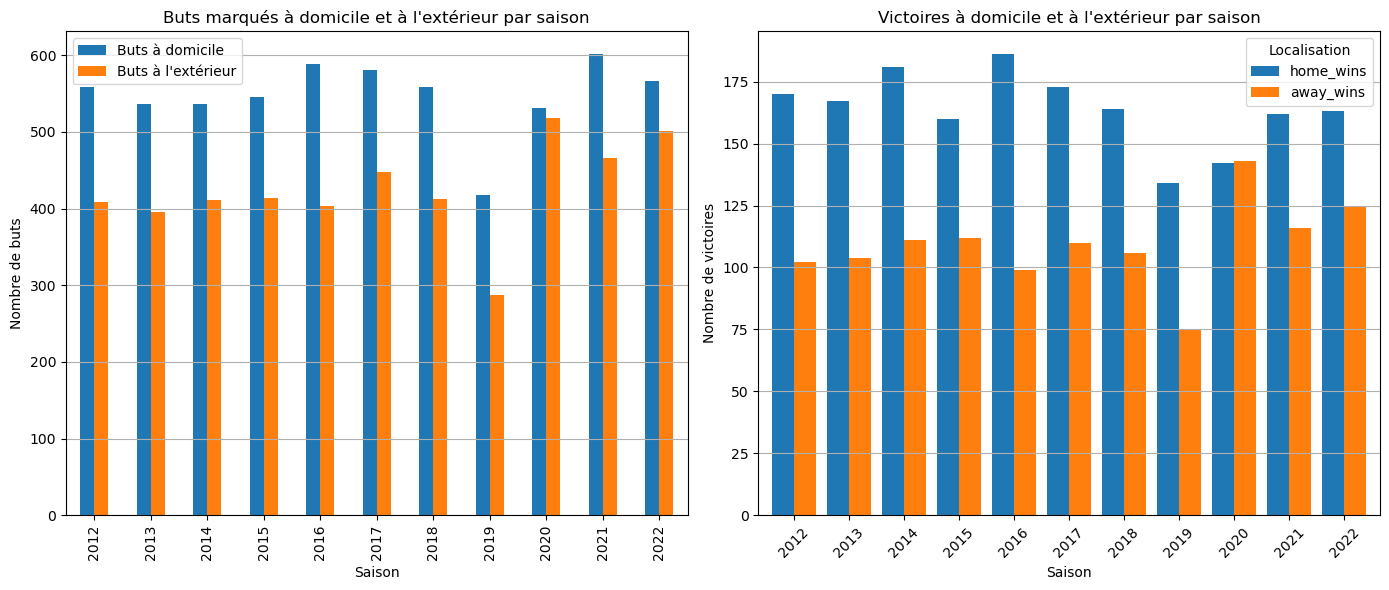

Pourcentage de différence moyen entre les victoires à domicile et à l'extérieur : 14.845087317033416


In [6]:
goals_by_season = matchs.groupby('season')[['home_club_goals', 'away_club_goals']].sum()
home_wins_by_season = matchs.loc[matchs['results'] == 1].groupby('season').size()
away_wins_by_season = matchs.loc[matchs['results'] == -1].groupby('season').size()
wins_by_season = pd.concat([home_wins_by_season, away_wins_by_season], axis=1)
wins_by_season.columns = ['home_wins', 'away_wins']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1
goals_by_season.plot(kind='bar', ax=ax1)
ax1.set_title('Buts marqués à domicile et à l\'extérieur par saison')
ax1.set_xlabel('Saison')
ax1.set_ylabel('Nombre de buts')
ax1.legend(['Buts à domicile', 'Buts à l\'extérieur'])
ax1.grid(axis='y')

# Plot 2
wins_by_season.plot(kind='bar', width=0.8, ax=ax2)
ax2.set_title('Victoires à domicile et à l\'extérieur par saison')
ax2.set_xlabel('Saison')
ax2.set_ylabel('Nombre de victoires')
ax2.set_xticks(range(len(wins_by_season.index)))
ax2.set_xticklabels(wins_by_season.index, rotation=45)
ax2.legend(title='Localisation')
ax2.grid(axis='y')

plt.tight_layout()
plt.show()



wins_diff_by_season = home_wins_by_season - away_wins_by_season
total_matches_by_season = matchs.groupby('season').size()
percentage_diff_by_season = (wins_diff_by_season / total_matches_by_season) * 100
average_percentage_diff = percentage_diff_by_season.mean()

print("Pourcentage de différence moyen entre les victoires à domicile et à l'extérieur :", average_percentage_diff)


On observe graphiquement une différence nette de performances entre les matchs à domicile et à l'extérieur, sauf pour l'année 2020, avec un public absent à cause du COVID, oû le nombre de but et de victoire à domicile et à l'exterieur sont presque egaux. Aussi, apès calcul, on observe une hausse des victoire à domicile d'environ 15% par rapport aux victoire à l'exterieur. On en conclut que le public à un impacte non négligeable sur l'issue du match.

#### Valeur financière totale 

In [14]:
pre_season['year'] = pd.to_datetime(pre_season['date']).dt.year
team_values = pre_season.groupby(['year', 'current_club_id'])['market_value_in_eur'].sum().reset_index()
print(team_values.head(300))
# mapper les ids des clubs aux noms des clubs
club_id_to_name = clubs.set_index('club_id')['name'].to_dict()
team_values['team_name'] = team_values['current_club_id'].map(club_id_to_name)

# filtrer les matchs pour les résultats
matchs = matchs[matchs['results'].notna()]

# créer une colonne pour les victoires des clubs à domicile et à l'extérieur
matchs['home_win'] = matchs['home_club_goals'] > matchs['away_club_goals']
matchs['away_win'] = matchs['away_club_goals'] > matchs['home_club_goals']


# les victoires à domicile et à l'extérieur par équipe et par année
home_wins = matchs[matchs['home_win']].groupby(['season', 'home_club_id']).size().reset_index(name='wins')
away_wins = matchs[matchs['away_win']].groupby(['season', 'away_club_id']).size().reset_index(name='wins')

home_wins = home_wins.rename(columns={'home_club_id': 'club_id'})
away_wins = away_wins.rename(columns={'away_club_id': 'club_id'})

# combiner les victoires à domicile et à l'extérieur
total_wins = pd.concat([home_wins, away_wins]).groupby(['season', 'club_id'])['wins'].sum().reset_index()

# modifier le club_id par le team_name
total_wins['team_name'] = total_wins['club_id'].map(club_id_to_name)


team_stats = pd.merge(team_values, total_wins, left_on=['year', 'current_club_id'], right_on=['season', 'club_id'])
team_stats = team_stats[['year', 'team_name_x', 'market_value_in_eur', 'wins']]
team_stats = team_stats.rename(columns={'team_name_x': 'team_name'})

# separation par annees
datasets_by_year = {year: data for year, data in team_stats.groupby('year')}
team_stats_by_year = {} # dictionnaire contenant les année pour faciliter la suite 
for year in range(2013, 2023):
    team_stats_year = team_stats[team_stats['year'] == year].sort_values(by='market_value_in_eur', ascending=False)
    team_stats_by_year[year] = team_stats_year
    

team_stats_by_year[2013]





     year  current_club_id  market_value_in_eur
0    2004               40             14100000
1    2004              162             38800000
2    2004              244             12700000
3    2004              273              9800000
4    2004              347             24750000
..    ...              ...                  ...
295  2012             3911             63850000
296  2012            14171             46700000
297  2013               40            180500000
298  2013              162            152000000
299  2013              244            277900000

[300 rows x 3 columns]


,year,team_name,market_value_in_eur,wins
26,2013,Paris Saint-Germain Football Club,556150000,27
22,2013,Olympique de Marseille,277900000,16
33,2013,Olympique Lyonnais,240550000,17
28,2013,AS Saint-Étienne,193350000,20
31,2013,Montpellier Hérault Sport Club,189625000,8
20,2013,FC Girondins Bordeaux,180500000,13
23,2013,Stade Rennais Football Club,158175000,11
21,2013,Association sportive de Monaco Football Club,152000000,23
34,2013,Lille Olympique Sporting Club Lille Métropole,149300000,20
25,2013,Olympique Gymnaste Club Nice Côte d'Azur,130750000,12


In [27]:
def calculate_match_stats(matches):
    home_stats = matches.groupby(['season', 'home_club_id']).agg(
        home_goals=('home_club_goals', 'sum'),
        home_position=('home_club_position', 'mean'),
        home_wins=('results', lambda x: sum(x == 'home_win'))
    ).reset_index()

    away_stats = matches.groupby(['season', 'away_club_id']).agg(
        away_goals=('away_club_goals', 'sum'),
        away_position=('away_club_position', 'mean'),
        away_wins=('results', lambda x: sum(x == 'away_win'))
    ).reset_index()

    combined_stats = pd.merge(home_stats, away_stats, left_on=['season', 'home_club_id'], right_on=['season', 'away_club_id'])
    combined_stats['total_goals'] = combined_stats['home_goals'] + combined_stats['away_goals']
    combined_stats['avg_position'] = (combined_stats['home_position'] + combined_stats['away_position']) / 2
    combined_stats['total_wins'] = combined_stats['home_wins'] + combined_stats['away_wins']
    
    return combined_stats[['season', 'home_club_id', 'total_goals', 'avg_position', 'total_wins']]

match_stats = calculate_match_stats(matchs)

match_stats.head(20)



,season,home_club_id,total_goals,avg_position,total_wins
0,2012,40,40,6.631579,0
1,2012,244,42,2.447368,0
2,2012,273,48,9.842105,0
3,2012,415,49,9.184211,0
4,2012,417,57,8.710526,0
5,2012,583,69,2.421053,0
6,2012,595,50,12.500000,0
7,2012,618,60,6.473684,0
8,2012,750,41,16.921053,0
9,2012,969,54,10.710526,0


In [28]:
def calculate_club_stats(clubs):
    club_stats = clubs[['club_id', 'squad_size', 'average_age', 'foreigners_number', 'foreigners_percentage', 'national_team_players', 'stadium_seats', 'net_transfer_record']]
    return club_stats

club_stats = calculate_club_stats(clubs)
club_stats.head(20)

,club_id,squad_size,average_age,foreigners_number,foreigners_percentage,national_team_players,stadium_seats,net_transfer_record
0,969,25,25.7,12,48.0,8,32939,+€28.60m
1,1082,25,25.4,18,72.0,7,50186,+€3.65m
2,1160,26,25.4,12,46.2,3,8033,+€2.50m
3,3911,24,26.0,6,25.0,3,15220,+€5.10m
4,595,25,27.6,8,32.0,6,16480,+€480k
5,1158,28,24.5,16,57.1,11,19010,+€30.30m
6,273,24,24.4,11,45.8,8,29778,+€62.10m
7,995,25,26.5,13,52.0,9,37463,+€10.85m
8,2969,29,25.8,14,48.3,4,16098,+€1.50m
9,40,26,22.7,13,50.0,6,42115,+€12.70m


In [29]:
def calculate_player_appearance_stats(appearances):
    player_stats = appearances.groupby(['player_club_id', 'date']).agg(
        total_goals=('goals', 'sum'),
        total_assists=('assists', 'sum'),
        total_yellow_cards=('yellow_cards', 'sum'),
        total_red_cards=('red_cards', 'sum'),
        total_minutes=('minutes_played', 'sum')
    ).reset_index()
    player_stats['date'] = pd.to_datetime(player_stats['date']).dt.year
    player_stats.rename(columns={'date': 'season'}, inplace=True)
    return player_stats

player_appearance_stats = calculate_player_appearance_stats(player_appearance)
player_appearance_stats.head(20)

,player_club_id,season,total_goals,total_assists,total_yellow_cards,total_red_cards,total_minutes
0,40,2012,3,3,3,0,990
1,40,2012,1,0,1,0,990
2,40,2012,0,0,1,0,990
3,40,2012,1,1,0,1,964
4,40,2012,0,0,2,0,990
5,40,2012,2,2,3,0,990
6,40,2012,2,0,2,0,991
7,40,2012,1,1,3,0,990
8,40,2012,1,1,2,0,990
9,40,2012,1,0,2,0,990


In [31]:
def merge_all_stats(match_stats, club_stats, player_appearance_stats):
    # Fusionner les stats des matchs avec les stats des clubs
    all_stats = pd.merge(match_stats, club_stats, left_on='home_club_id', right_on='club_id', how='left')
    
    # Fusionner avec les stats des apparitions des joueurs
    all_stats = pd.merge(all_stats, player_appearance_stats, left_on=['home_club_id', 'season'], right_on=['player_club_id', 'season'], how='left')
    
    return all_stats

all_stats = merge_all_stats(match_stats, club_stats, player_appearance_stats)
all_stats.head(50)


,season,home_club_id,total_goals_x,avg_position,total_wins,club_id,squad_size,average_age,foreigners_number,foreigners_percentage,national_team_players,stadium_seats,net_transfer_record,player_club_id,total_goals_y,total_assists,total_yellow_cards,total_red_cards,total_minutes
0,2012,40,40,6.631579,0,40,26,22.7,13,50.0,6,42115,+€12.70m,40,3,3,3,0,990
1,2012,40,40,6.631579,0,40,26,22.7,13,50.0,6,42115,+€12.70m,40,1,0,1,0,990
2,2012,40,40,6.631579,0,40,26,22.7,13,50.0,6,42115,+€12.70m,40,0,0,1,0,990
3,2012,40,40,6.631579,0,40,26,22.7,13,50.0,6,42115,+€12.70m,40,1,1,0,1,964
4,2012,40,40,6.631579,0,40,26,22.7,13,50.0,6,42115,+€12.70m,40,0,0,2,0,990
5,2012,40,40,6.631579,0,40,26,22.7,13,50.0,6,42115,+€12.70m,40,2,2,3,0,990
6,2012,40,40,6.631579,0,40,26,22.7,13,50.0,6,42115,+€12.70m,40,2,0,2,0,991
7,2012,40,40,6.631579,0,40,26,22.7,13,50.0,6,42115,+€12.70m,40,1,1,3,0,990
8,2012,40,40,6.631579,0,40,26,22.7,13,50.0,6,42115,+€12.70m,40,1,1,2,0,990
9,2012,40,40,6.631579,0,40,26,22.7,13,50.0,6,42115,+€12.70m,40,1,0,2,0,990


In [25]:
def merge_all_stats(match_stats, club_stats, player_appearance_stats):
    # Fusionner match_stats et club_stats sur 'home_club_name' et 'club_name'
    all_stats = pd.merge(match_stats, club_stats, left_on='home_club_name', right_on='club_name', how='left')
    
    # Fusionner all_stats et player_appearance_stats sur 'club_id' et 'season'
    all_stats = pd.merge(all_stats, player_appearance_stats, left_on=['club_id', 'season'], right_on=['player_current_club_id', 'season'], how='left')
    
    return all_stats

all_stats = merge_all_stats(match_stats, club_stats, player_appearance_stats)



KeyError: 'season'

In [ ]:
team_stats_by_year = {year: {} for year in range(2013, 2024)}

for year in range(2013, 2024):
    yearly_stats = all_stats[all_stats['season'] == year]
    
    for team in yearly_stats['home_club_name'].unique():
        team_data = yearly_stats[yearly_stats['home_club_name'] == team]
        team_stats_by_year[year][team] = {
            'market_value_in_eur': team_data['market_value_in_eur'].values[0] if not team_data['market_value_in_eur'].isna().all() else np.nan,
            'wins': team_data['total_wins'].values[0] if not team_data['total_wins'].isna().all() else np.nan,
            'total_goals': team_data['total_goals'].values[0] if not team_data['total_goals'].isna().all() else np.nan,
            'avg_position': team_data['avg_position'].values[0] if not team_data['avg_position'].isna().all() else np.nan,
            'squad_size': team_data['squad_size'].values[0] if not team_data['squad_size'].isna().all() else np.nan,
            'average_age': team_data['average_age'].values[0] if not team_data['average_age'].isna().all() else np.nan,
            'foreigners_number': team_data['foreigners_number'].values[0] if not team_data['foreigners_number'].isna().all() else np.nan,
            'foreigners_percentage': team_data['foreigners_percentage'].values[0] if not team_data['foreigners_percentage'].isna().all() else np.nan,
            'national_team_players': team_data['national_team_players'].values[0] if not team_data['national_team_players'].isna().all() else np.nan,
            'stadium_seats': team_data['stadium_seats'].values[0] if not team_data['stadium_seats'].isna().all() else np.nan,
            'net_transfer_record': team_data['net_transfer_record'].values[0] if not team_data['net_transfer_record'].isna().all() else np.nan,
            'total_assists': team_data['total_assists'].values[0] if not team_data['total_assists'].isna().all() else np.nan,
            'total_yellow_cards': team_data['total_yellow_cards'].values[0] if not team_data['total_yellow_cards'].isna().all() else np.nan,
            'total_red_cards': team_data['total_red_cards'].values[0] if not team_data['total_red_cards'].isna().all() else np.nan,
            'total_minutes': team_data['total_minutes'].values[0] if not team_data['total_minutes'].isna().all() else np.nan
        }


In [33]:
# Importer les librairies
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# standardiser les données
scaler = StandardScaler()
Z = scaler.fit_transform(pre_season)

# créer le model de la PCA 
pca = PCA(n_components=2)

# appliquer la PCA à la base de donnée
pca.fit(Z)

# projeter les données
x_pca = pca.transform(Z)

# Obtenir les composantes principales
pca.components_

# Obtenir les variances expliquées 
pca.explained_variance_

# Obtenir les proportions des variances expliquées 

pca.explained_variance_ratio_




c:\Users\Nizar\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


ValueError: could not convert string to float: '2004-10-04'